In [2]:
import urllib.request
import json
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook
import numpy as np
import datetime
import pandas as pd

### Выкачиваем посты из паблика "ВДудь"

In [3]:
token = ''
version = '5.92'
domain = 'vdud'

posts = []
offset = 0
while True:
    req = urllib.request.Request('https://api.vk.com/method/wall.get?domain=%s&count=100&access_token=%s&v=%s&offset=%s'  % (domain, token, version, offset))
    response = urllib.request.urlopen(req)
    result = response.read().decode('utf-8')
    data = json.loads(result)
    if (data['response']['items'] == []) or offset > 1000:
        break
    else:
        posts.extend(data['response']['items'])
        offset += 100
len(posts)

403

#### Сохраняем нужную информацию в датафрейм и конвертируем дату

In [109]:
posts_df = pd.DataFrame([[post['id'],
  post['text'],
  post['date'],
  post['likes']['count'],
  post['reposts']['count'],
  post['views']['count']] for post in posts], columns=['post_id','text','date','likes','reposts','views'])

posts_df['date'] = pd.to_datetime(posts_df.date, unit= 's')

In [111]:
posts_df.head()

,post_id,text,date,likes,reposts,views
0,203278,NEXTA – главное медиа белорусского протеста ⁄ ...,2020-09-18 07:26:12,2881,232,156032
1,202858,Глуховский – рок-звезда русской литературы / в...,2020-09-10 13:19:16,2920,412,157544
2,202563,Юра Борисов – «новый Петров» и прыжок с обрыва...,2020-09-01 10:14:33,2307,179,201282
3,202255,"Наши кореша из ""Вписки"" сделали выпуск про важ...",2020-08-14 16:47:23,617,21,117482
4,202053,Козырев – любить страну и ненавидеть государст...,2020-08-13 18:40:20,2316,265,174400


#### Не получилось скачать больше 1000 постов, поэтому будет скачивать комментарии пользователей

In [8]:
owner_id = '-145800770'

comments_list = []
users = []
for post in tqdm_notebook(posts):
    if (len(users)>100) and (len(comments_list)>1000):
        break
    post_id = post['id']
    off = 0
    while True:
        req = urllib.request.Request(f'https://api.vk.com/method/wall.getComments?owner_id={owner_id}&post_id={post_id}&count=100&access_token={token}&v={version}&offset={off}')
        time.sleep(0.2)
        response = urllib.request.urlopen(req)
        result = response.read().decode('utf-8')
        data = json.loads(result)
        if data['response']['items'] == []:
            break
        else:
            for comment in data['response']['items']:
                if 'from_id' not in comment:
                    continue
                user_id = comment['from_id']
                if user_id not in users:
                    users.append(user_id)
            
            comments_list.extend(data['response']['items'])
            off += 100
    print(f'comments: {len(comments_list)}, users: {len(users)}')
print(len(comments_list))

comments: 161, users: 153



Exception in thread Thread-8:
Traceback (most recent call last):
  File "C:\Users\Mi\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Mi\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Mi\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



comments: 305, users: 277
comments: 435, users: 389
comments: 494, users: 433
comments: 620, users: 528
comments: 774, users: 639
comments: 897, users: 725
comments: 1299, users: 1002

1299


### Тоже кладем в датафрейм и конвертируем дату

In [33]:
comments_df = pd.DataFrame([[comment['id'],
                             comment['post_id'],
                             comment['from_id'],
                             comment['date'],
                             comment['text']] for comment in comments_list if 'deleted' not in comment], columns=['comment_id','post_id','user_id','date','text'])

comments_df['date'] = pd.to_datetime(comments_df.date, unit= 's')

In [108]:
comments_df.head()

,comment_id,post_id,user_id,date,text
0,203279,203278,514602465,2020-09-18 07:28:21,опять ноунеймы какие то
1,203280,203278,145613746,2020-09-18 07:29:08,Я не успеваю смотреть)) горшочек не вари)
2,203290,203278,254457927,2020-09-18 07:32:13,"Спасибо, Юра, что не зыбыл о наших братьях"
3,203293,203278,483875039,2020-09-18 07:32:17,Не нравятся мне эти протесты...
4,203296,203278,984648,2020-09-18 07:33:46,"норм, наконец-таки будем посмотреть."


### Собираем информацию про пользователей

In [12]:
users_info = {}
for user_id in tqdm_notebook(users):
    req = urllib.request.Request(f'https://api.vk.com/method/users.get?user_ids={user_id}&fields=sex,bdate&access_token={token}&v={version}')
    time.sleep(0.2)
    response = urllib.request.urlopen(req)
    result = response.read().decode('utf-8')
    data = json.loads(result) 
    if 'error' in data:
        continue
    param_dict = {}
    param_dict['sex'] = data['response'][0]['sex']
    if 'bdate' not in data['response'][0]:
        continue
    param_dict['bday'] = data['response'][0]['bdate']
    users_info[user_id] = param_dict

Exception in thread Thread-9:
Traceback (most recent call last):
  File "C:\Users\Mi\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Mi\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Mi\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



### Кладем в датафрейм и чистим данные, приводим их в нормальный вид и вычисляем возраст

In [96]:
users_df = pd.DataFrame.from_dict(users_info, orient='index').reset_index().rename(columns={'index':'user_id'})

In [95]:
def clean_date(date):
    dates = date.split('.')
    if len(dates) > 2:
        day, month, year = dates
    else:
        day, month = dates
        # я решила поставить тем, у кого нет года рождения, такой год, чтобы они выделялись
        year = '1720'
    if len(day) < 2:
        day = '0' + day
    if len(month) < 2:
        month = '0' + month
    return f'{day}/{month}/{year}'

In [97]:
users_df['bday'] = users_df['bday'].apply(clean_date)
users_df['bday'] = pd.to_datetime(users_df.bday, format='%d/%m/%Y')

users_df.sex = users_df.sex.apply(lambda x: {1:'m',2:'f'}[x])

In [121]:
def from_dob_to_age(born):
    today = datetime.date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

In [124]:
users_df['age'] = users_df.bday.apply(from_dob_to_age)
users_df.age[users_df.age >= 299] = np.nan

### Лемматизируем тексты постов и комментариев

In [137]:
import pymorphy2
from string import punctuation
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")

def preprocess(text):
    morph = pymorphy2.MorphAnalyzer()
    tokens = nltk.tokenize.word_tokenize(text.lower())
    tokens = [morph.parse(word)[0].normal_form for word in tokens if word not in russian_stopwords\
              and word != " " \
              and word.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [149]:
from tqdm import tqdm

In [150]:
tqdm.pandas()
posts_df['lemmatized'] = posts_df.text.progress_apply(preprocess)
comments_df['lemmatized'] = comments_df.text.progress_apply(preprocess)



  0%|                                                                                          | 0/403 [00:00<?, ?it/s]

  1%|▌                                                                                 | 3/403 [00:00<00:17, 22.45it/s]

  1%|█                                                                                 | 5/403 [00:00<00:19, 20.04it/s]

  2%|█▍                                                                                | 7/403 [00:00<00:21, 18.20it/s]

  2%|█▊                                                                                | 9/403 [00:00<00:22, 17.54it/s]

  3%|██▏                                                                              | 11/403 [00:00<00:22, 17.14it/s]

  3%|██▌                                                                              | 13/403 [00:00<00:23, 16.45it/s]

  4%|███                                                                              | 15/403 [00:00<00:24, 16.13it/s]

  4%|███▍                     

 33%|██████████████████████████▊                                                     | 135/403 [00:10<00:17, 15.34it/s]

 34%|███████████████████████████▏                                                    | 137/403 [00:10<00:16, 15.73it/s]

 34%|███████████████████████████▌                                                    | 139/403 [00:10<00:16, 16.02it/s]

 35%|███████████████████████████▉                                                    | 141/403 [00:10<00:16, 16.03it/s]

 35%|████████████████████████████▍                                                   | 143/403 [00:10<00:16, 15.73it/s]

 36%|████████████████████████████▊                                                   | 145/403 [00:10<00:16, 15.94it/s]

 36%|█████████████████████████████▏                                                  | 147/403 [00:11<00:17, 15.03it/s]

 37%|█████████████████████████████▌                                                  | 149/403 [00:11<00:18, 14.01it/s]

 37%|███████████████████████████

 66%|█████████████████████████████████████████████████████                           | 267/403 [00:20<00:09, 14.65it/s]

 67%|█████████████████████████████████████████████████████▍                          | 269/403 [00:20<00:09, 14.84it/s]

 67%|█████████████████████████████████████████████████████▊                          | 271/403 [00:20<00:08, 14.75it/s]

 68%|██████████████████████████████████████████████████████▏                         | 273/403 [00:21<00:19,  6.57it/s]

 68%|██████████████████████████████████████████████████████▌                         | 275/403 [00:21<00:15,  8.05it/s]

 69%|██████████████████████████████████████████████████████▉                         | 277/403 [00:21<00:13,  9.53it/s]

 69%|███████████████████████████████████████████████████████▍                        | 279/403 [00:21<00:11, 11.05it/s]

 70%|███████████████████████████████████████████████████████▊                        | 281/403 [00:21<00:09, 12.32it/s]

 70%|███████████████████████████

100%|███████████████████████████████████████████████████████████████████████████████▌| 401/403 [00:30<00:00, 12.16it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 403/403 [00:31<00:00, 12.85it/s]



  0%|                                                                                         | 0/1294 [00:00<?, ?it/s]

  0%|▏                                                                                | 3/1294 [00:00<00:53, 24.26it/s]

  0%|▎                                                                                | 5/1294 [00:00<01:07, 19.10it/s]

  1%|▍                                                                                | 7/1294 [00:00<01:16, 16.76it/s]

  1%|▌                                                                                | 9/1294 [00:00<01:18, 16.29it/s]

  1%|▋                                                                               | 11/1294 [00:00<01:21, 15.71it/s]

  1%|▊                        

 10%|███████▉                                                                       | 131/1294 [00:10<01:16, 15.28it/s]

 10%|████████                                                                       | 133/1294 [00:10<01:16, 15.18it/s]

 10%|████████▏                                                                      | 135/1294 [00:10<01:17, 14.88it/s]

 11%|████████▎                                                                      | 137/1294 [00:10<01:19, 14.58it/s]

 11%|████████▍                                                                      | 139/1294 [00:10<01:18, 14.66it/s]

 11%|████████▌                                                                      | 141/1294 [00:10<01:17, 14.92it/s]

 11%|████████▋                                                                      | 143/1294 [00:10<01:15, 15.31it/s]

 11%|████████▊                                                                      | 145/1294 [00:11<02:33,  7.47it/s]

 11%|████████▉                  

 20%|████████████████▏                                                              | 265/1294 [00:19<01:10, 14.55it/s]

 21%|████████████████▎                                                              | 267/1294 [00:19<01:07, 15.14it/s]

 21%|████████████████▍                                                              | 269/1294 [00:20<01:09, 14.79it/s]

 21%|████████████████▌                                                              | 271/1294 [00:20<01:08, 14.86it/s]

 21%|████████████████▋                                                              | 273/1294 [00:20<01:07, 15.09it/s]

 21%|████████████████▊                                                              | 275/1294 [00:20<01:06, 15.26it/s]

 21%|████████████████▉                                                              | 277/1294 [00:20<01:04, 15.69it/s]

 22%|█████████████████                                                              | 279/1294 [00:20<01:03, 15.91it/s]

 22%|█████████████████▏         

 31%|████████████████████████▎                                                      | 399/1294 [00:29<00:57, 15.46it/s]

 31%|████████████████████████▍                                                      | 401/1294 [00:29<00:58, 15.24it/s]

 31%|████████████████████████▌                                                      | 403/1294 [00:29<00:57, 15.62it/s]

 31%|████████████████████████▋                                                      | 405/1294 [00:29<00:56, 15.63it/s]

 31%|████████████████████████▊                                                      | 407/1294 [00:29<00:57, 15.46it/s]

 32%|████████████████████████▉                                                      | 409/1294 [00:29<00:57, 15.34it/s]

 32%|█████████████████████████                                                      | 411/1294 [00:30<00:57, 15.33it/s]

 32%|█████████████████████████▏                                                     | 413/1294 [00:30<00:56, 15.65it/s]

 32%|█████████████████████████▎ 

 41%|████████████████████████████████▌                                              | 533/1294 [00:39<01:24,  9.04it/s]

 41%|████████████████████████████████▋                                              | 535/1294 [00:40<01:17,  9.82it/s]

 41%|████████████████████████████████▊                                              | 537/1294 [00:40<01:08, 11.00it/s]

 42%|████████████████████████████████▉                                              | 539/1294 [00:40<01:02, 12.06it/s]

 42%|█████████████████████████████████                                              | 541/1294 [00:40<00:57, 13.17it/s]

 42%|█████████████████████████████████▏                                             | 543/1294 [00:40<00:52, 14.24it/s]

 42%|█████████████████████████████████▎                                             | 545/1294 [00:40<00:49, 15.27it/s]

 42%|█████████████████████████████████▍                                             | 547/1294 [00:40<00:46, 15.94it/s]

 42%|███████████████████████████

 52%|████████████████████████████████████████▋                                      | 667/1294 [00:48<00:37, 16.73it/s]

 52%|████████████████████████████████████████▊                                      | 669/1294 [00:48<00:37, 16.82it/s]

 52%|████████████████████████████████████████▉                                      | 671/1294 [00:48<00:36, 17.02it/s]

 52%|█████████████████████████████████████████                                      | 673/1294 [00:49<00:35, 17.27it/s]

 52%|█████████████████████████████████████████▏                                     | 675/1294 [00:49<00:39, 15.85it/s]

 52%|█████████████████████████████████████████▎                                     | 677/1294 [00:49<00:40, 15.26it/s]

 52%|█████████████████████████████████████████▍                                     | 679/1294 [00:49<00:39, 15.41it/s]

 53%|█████████████████████████████████████████▌                                     | 681/1294 [00:49<00:40, 15.31it/s]

 53%|███████████████████████████

 62%|████████████████████████████████████████████████▉                              | 801/1294 [00:58<00:30, 16.06it/s]

 62%|█████████████████████████████████████████████████                              | 803/1294 [00:59<01:18,  6.28it/s]

 62%|█████████████████████████████████████████████████▏                             | 805/1294 [00:59<01:03,  7.70it/s]

 62%|█████████████████████████████████████████████████▎                             | 807/1294 [00:59<00:52,  9.23it/s]

 63%|█████████████████████████████████████████████████▍                             | 809/1294 [00:59<00:45, 10.59it/s]

 63%|█████████████████████████████████████████████████▌                             | 811/1294 [00:59<00:41, 11.65it/s]

 63%|█████████████████████████████████████████████████▋                             | 813/1294 [01:00<00:38, 12.36it/s]

 63%|█████████████████████████████████████████████████▊                             | 815/1294 [01:00<00:37, 12.87it/s]

 63%|███████████████████████████

 72%|█████████████████████████████████████████████████████████                      | 935/1294 [01:08<00:24, 14.67it/s]

 72%|█████████████████████████████████████████████████████████▏                     | 937/1294 [01:09<00:23, 15.51it/s]

 73%|█████████████████████████████████████████████████████████▎                     | 939/1294 [01:09<00:22, 15.63it/s]

 73%|█████████████████████████████████████████████████████████▍                     | 941/1294 [01:09<00:23, 15.25it/s]

 73%|█████████████████████████████████████████████████████████▌                     | 943/1294 [01:09<00:23, 14.79it/s]

 73%|█████████████████████████████████████████████████████████▋                     | 945/1294 [01:09<00:23, 14.62it/s]

 73%|█████████████████████████████████████████████████████████▊                     | 947/1294 [01:09<00:23, 14.83it/s]

 73%|█████████████████████████████████████████████████████████▉                     | 949/1294 [01:09<00:22, 15.35it/s]

 73%|███████████████████████████

 83%|████████████████████████████████████████████████████████████████▍             | 1069/1294 [01:18<00:13, 16.25it/s]

 83%|████████████████████████████████████████████████████████████████▌             | 1071/1294 [01:18<00:13, 16.42it/s]

 83%|████████████████████████████████████████████████████████████████▋             | 1073/1294 [01:18<00:13, 15.88it/s]

 83%|████████████████████████████████████████████████████████████████▊             | 1075/1294 [01:18<00:14, 15.49it/s]

 83%|████████████████████████████████████████████████████████████████▉             | 1077/1294 [01:19<00:28,  7.63it/s]

 83%|█████████████████████████████████████████████████████████████████             | 1079/1294 [01:19<00:23,  9.16it/s]

 84%|█████████████████████████████████████████████████████████████████▏            | 1081/1294 [01:19<00:20, 10.52it/s]

 84%|█████████████████████████████████████████████████████████████████▎            | 1083/1294 [01:19<00:17, 12.01it/s]

 84%|███████████████████████████

 93%|████████████████████████████████████████████████████████████████████████▌     | 1203/1294 [01:27<00:06, 14.49it/s]

 93%|████████████████████████████████████████████████████████████████████████▋     | 1205/1294 [01:28<00:06, 14.41it/s]

 93%|████████████████████████████████████████████████████████████████████████▊     | 1207/1294 [01:28<00:05, 14.89it/s]

 93%|████████████████████████████████████████████████████████████████████████▉     | 1209/1294 [01:28<00:05, 15.26it/s]

 94%|████████████████████████████████████████████████████████████████████████▉     | 1211/1294 [01:28<00:05, 15.52it/s]

 94%|█████████████████████████████████████████████████████████████████████████     | 1213/1294 [01:28<00:05, 15.97it/s]

 94%|█████████████████████████████████████████████████████████████████████████▏    | 1215/1294 [01:28<00:04, 16.31it/s]

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1217/1294 [01:28<00:04, 15.77it/s]

 94%|███████████████████████████

In [151]:
posts_df.head()

,post_id,text,date,likes,reposts,views,lemmatized
0,203278,NEXTA – главное медиа белорусского протеста ⁄ ...,2020-09-18 07:26:12,2881,232,156032,nexta – главный медиа белорусский протест ⁄ вд...
1,202858,Глуховский – рок-звезда русской литературы / в...,2020-09-10 13:19:16,2920,412,157544,глуховский – рок-звезда русский литература вду...
2,202563,Юра Борисов – «новый Петров» и прыжок с обрыва...,2020-09-01 10:14:33,2307,179,201282,юра борис – « новый петров » прыжок обрыв вдуд...
3,202255,"Наши кореша из ""Вписки"" сделали выпуск про важ...",2020-08-14 16:47:23,617,21,117482,наш кореш `` вписка '' сделать выпуск важный г...
4,202053,Козырев – любить страну и ненавидеть государст...,2020-08-13 18:40:20,2316,265,174400,козырев – любить страна ненавидеть государство...


In [152]:
comments_df.head()

,comment_id,post_id,user_id,date,text,lemmatized
0,203279,203278,514602465,2020-09-18 07:28:21,опять ноунеймы какие то,ноунейм какой
1,203280,203278,145613746,2020-09-18 07:29:08,Я не успеваю смотреть)) горшочек не вари),успевать смотреть горшочек варя
2,203290,203278,254457927,2020-09-18 07:32:13,"Спасибо, Юра, что не зыбыл о наших братьях",спасибо юра зыбыть наш брат
3,203293,203278,483875039,2020-09-18 07:32:17,Не нравятся мне эти протесты...,нравиться протест ...
4,203296,203278,984648,2020-09-18 07:33:46,"норм, наконец-таки будем посмотреть.",норма наконец-таки быть посмотреть


### Сохраняем все в базу данных

In [153]:
import sqlite3

In [154]:
import pandas.io.sql as pd_sql

In [163]:
con = sqlite3.connect('vk_api.db')
c = con.cursor()

In [168]:
pd_sql.to_sql(users_df, "users", con, index=False, if_exists='replace')
pd_sql.to_sql(posts_df, "posts", con, index=False, if_exists='replace')
pd_sql.to_sql(comments_df, "comments", con, index=False, if_exists='replace')

In [170]:
con.commit()

### Анализ

#### Интересно посмотреть на зависимость лайков, просмотров и репостов от дня недели поста

In [176]:
posts_df['dow'] = posts_df.date.apply(lambda x: x.weekday())

Text(0.5, 1.1, 'Activity depending on the day of week')

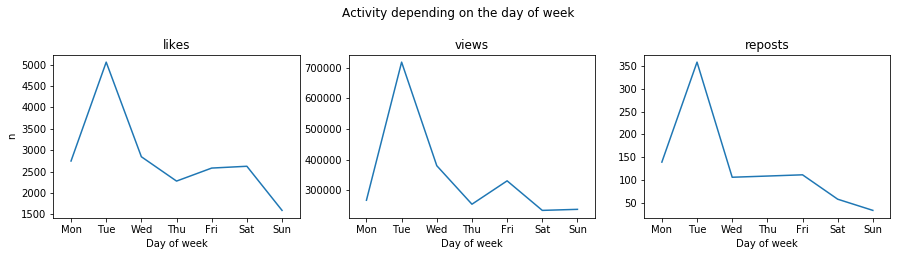

In [211]:
fig, ax = plt.subplots(1,3, figsize=(15,3))

posts_df.groupby('dow').likes.mean().plot(ax=ax[0], title='likes')
posts_df.groupby('dow').views.mean().plot(ax=ax[1], title='views')
posts_df.groupby('dow').reposts.mean().plot(ax=ax[2], title='reposts')

ax[0].set_ylabel('n')
for x in ax.flatten():
    x.set_xticks(ticks=np.arange(7))
    x.set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
    x.set_xlim(-0.5,6.5)
    x.set_xlabel('Day of week')
plt.suptitle('Activity depending on the day of week',y=1.1)


Видно, что самый популярный день недели - это вторник, по вторникам больше всего лайков, репостов и просмотров.

#### Посмотрим на отношение длины комментария и возраста комментатора 

In [228]:
comments_df = pd.merge(comments_df, users_df[['user_id','age','sex']],on='user_id')

In [214]:
comments_df['len'] = comments_df.lemmatized.apply(lambda x: len(x.split()))

Text(0.5, 1.0, 'Length of the comment by age')

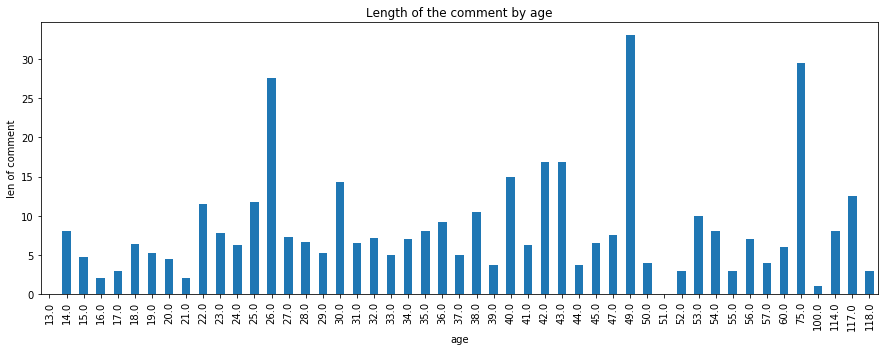

In [227]:
comments_df.groupby('age').len.mean().plot('bar', figsize=(15,5))
plt.ylabel('len of comment')
plt.title('Length of the comment by age')

Вообще прямой зависимости нет, но, видимо, у 26-, 45- и 75-летних людей особенно развиваются способности комментирования

#### Посмотрим на отношение длины комментария и пола комментатора

(array([0, 1]), <a list of 2 Text xticklabel objects>)

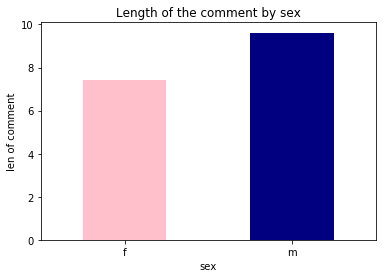

In [234]:
comments_df.groupby('sex').len.mean().plot('bar', color=['pink','navy'])
plt.ylabel('len of comment')
plt.title('Length of the comment by sex')
plt.xticks(rotation=0)

В среднем мужчины пишут более длинные комментарии, чем женщины

#### Найдем самые популярные слова для возрастных групп

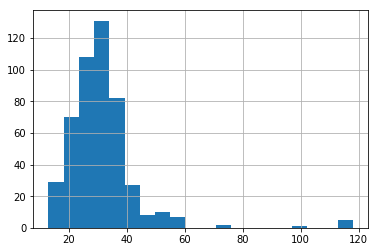

In [260]:
comments_df.age.hist(bins=20)

Разделим примерно поровну на 4 возрастные группы

In [268]:
comments_df.age[comments_df.age <= 25].count()

147

In [269]:
comments_df.age.loc[(comments_df.age > 25) & (comments_df.age <= 30)].count()

118

In [263]:
comments_df.age.loc[(comments_df.age > 30) & (comments_df.age <= 35)].count()

106

In [265]:
comments_df.age[comments_df.age > 35].count()

109

In [272]:
boundaries = [(0,25),(25,30),(30,35),(35,120)]
group_lexicon = []
for i,j in boundaries:
    comments = comments_df.loc[(comments_df.age > i) & (comments_df.age <= j)].lemmatized.tolist()
    lexicon = []
    for comment in comments:
        lexicon.extend(comment.split())
    group_lexicon.append(lexicon)

Считаем общий лексикон для каждой группы

In [287]:
for group in group_lexicon:
    for x in ['это','``',"''",'https','...']:
        while True:
            try:
                index = group.index(x)
            except ValueError:
                break
            group.pop(index)

In [274]:
from collections import Counter

In [288]:
group_freq=[]
for group in group_lexicon:
    freq = Counter(group).most_common(20)
    group_freq.append(freq)

In [294]:
lexicon = []
for n, group in enumerate(group_freq):
    for word, count in group:
        if word not in lexicon:
            lexicon.append(word)
len(lexicon)

49

In [295]:
freq = np.zeros((4,49))
for n, group in enumerate(group_freq):
    for word, count in group:
        i = lexicon.index(word)
        freq[n,i] = count

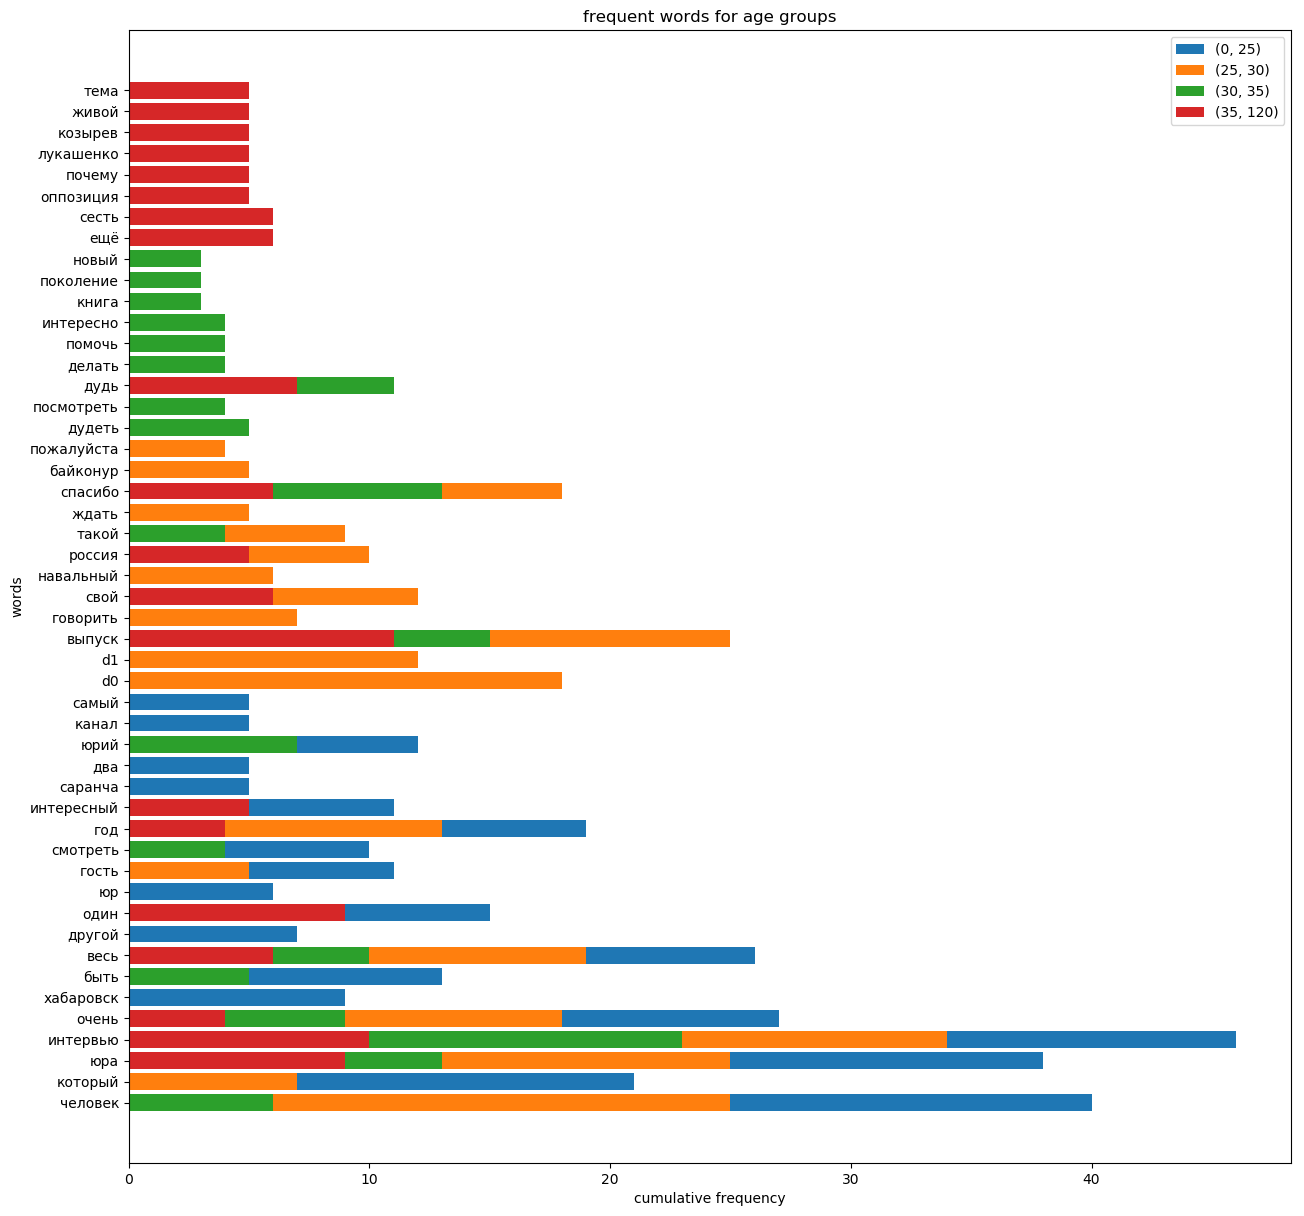

In [318]:
# строим график самых частотных слов по нелемматизированным текстам
plt.figure(figsize=(15, 15), dpi=100)
for n in range(4):
    plt.barh(lexicon, freq[n:4,:].sum(axis=0), label=boundaries[n])
plt.title('frequent words for age groups')
plt.xlabel("cumulative frequency")
plt.ylabel("words")
plt.legend()
plt.savefig('20_most_freq_lemm_age_group.png')
plt.show()

В общих частых словах много слов относящихся к интревью или Юрию или России.
По группам:
* группа >35 говорит про оппозицию, козырева, лукашенко
* группа 30-35 говорит про поколения и помощь
* группа 25-30 говорит про байконур и навального, и что-то просит
* группа <25 говорит про Хабаровск, саранчу и называет Юру "юр"